**Natalia Castilla Reyes**

**Miguel Angel Quintero**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


-----------------------------------------------------------------------

# 📑 Pronóstico de las ventas de diversos productos y evaluación de la satisfacción de los clientes de Walmart (US) mediante redes neuronales.

----------------------------------------------------------

In [ ]:
#@title Instalación dependencias
!pip install --upgrade plotly
!pip install -q findspark
!pip install "dask[array]"       # Install requirements for dask array
!pip install "dask[dataframe]"   # Install requirements for dask dataframe
!pip install "dask[diagnostics]" # Install requirements for dask diagnostics
!pip install "dask[distributed]" # Install requirements for distributed dask

     |████████████████████████████████| 20.6 MB 1.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 118 kB 5.3 MB/s 
     |████████████████████████████████| 769 kB 5.2 MB/s 
     |████████████████████████████████| 766 kB 11.3 MB/s 
     |████████████████████████████████| 1.0 MB 22.3 MB/s 
     |████████████████████████████████| 722 kB 40.2 MB/s 
     |████████████████████████████████| 722 kB 43.0 MB/s 
     |████████████████████████████████| 715 kB 68.7 MB/s 
     |████████████████████████████████| 705 kB 38.0 MB/s 
     |████████████████████████████████| 699 kB 44.8 MB/s 
     |████████████████████████████████| 696 kB 55.9 MB/s 
     |████████████████████████████████| 684 kB 69.4 MB/s 
     |████████████████████████████████| 679 kB 63.8 MB/s 
     |████████████████████████████████| 675 kB 77.7 MB/s 
     |████████████████████████████████

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
#######################SPARK
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz

In [ ]:
#@title Librerias necesarias
#Librerias generales

import time
import math
import datetime

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import pickle
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import dask
import joblib
from dask.dataframe import DataFrame as dd
import warnings

#Configuraciones
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 400

#########Modelos

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor




from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Tensor Flow
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)
# optimizador
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping


##Para definir la funcion de perdida que necesitaos en keeras

from keras import backend as K

#Variable global

DAYS_PRED = 28
ruta = "/content/drive/MyDrive/Proyecto_topicos/"

Versión de Tensorflow:  2.5.0




##1. 📌 Motivación del proyecto

Realizar correctamente el pronóstico de las ventas de ciertos productos es de gran relevancia para cierto tipo de empresas ya que así pueden tener una medición de la demanda de sus productos. Al tener una idea de la demanda de sus productos, las empresas pueden adelantarse a las necesidades de sus clientes y de esta manera tomar decisiones de negocio. Algunas de las decisiones de negocio usuales son: **asegurarse de contratar el número suficiente de empleados, tener un presupuesto aproximado de los gastos operativos y realizar el correcto restock de los productos**. Por lo anterior, realizar malos pronósticos conduce a pérdidas monetarias en la empresa, como los gastos generados al acumular un excedente de productos en épocas de baja demanda o la pérdida de beneficios
cuando hay escasez de suministros y hay una gran demanda de estos. 

Este trabajo se dividirá en dos partes:
1. Se realizará un pronostico del volumen de ventas para cada una de las tiendas.

2. Se evaluará la satisfacción de los clientes de Walmart mediante análisis de sentimientos de tweets.

**Esto con el objetivo de obtener una perspectiva más completa de las necesidades del cliente y permitir una mejor toma de decisiones.**

##2. Planteamiento del problema

Para realizar los pronósticos de las ventas, se emplearán los datos de la competencia de Kaggle: https://www.kaggle.com/c/m5-forecasting-accuracy/data. La tarea consiste en predecir el volumen de ventas (es decir, el número de productos vendidos) para 3.049 productos de Walmart y para cada una de sus tiendas, durante un período de 28 días. Los productos abarcan 3 categorías (Hobbies, Hogar, Alimentación) y 7 departamentos en 3 estados (CA, TX, WI). En resumen, la entrada de nuestro algoritmo es
una serie temporal del volumen de ventas de cada producto durante los últimos 2 años. Finalmente, emplearemos distintos tipos y arquitecturas de redes neuronales para resolver este problema.

Por otra parte, para evaluar la satisfacción del cliente se emplearán los tweets, que se extraeran mediante la API de https://twitter.com/. Los tweets de interés serán los relacionados con Walmart y serán seleccionados según los 7 departamentos en 3 estados de nuestra fuente de datos proporcionada por Kaggle.


## Pronostico del volumen de ventas

### 💾 Descripción de los datos 

**Los datos:** Los datos fueron recolectados en 3 diferentes estados de USA: California (CA), Texas (TX) y Wisconsin (WI). La información de las ventas se encuentra registrada entre Enero del 2011 y Junio del 2016.Por otra parte, los datos comprenden 3049 productos individuales de 3 categorías y 7 departamentos, vendidos en 10 tiendas de 3 estados. Por lo tanto, podemos crear diversas series temporales por ejemplo: podemos crear 1 serie temporal para todas las ventas, 3 series temporales para todas las ventas por estado, y así sucesivamente. La categoría más grande son las ventas de todos los productos individuales 3049 por 10 tiendas para 30490 series temporales.

*Los datos de entrenamiento comprenden 3 archivos:*

*  sell_prices.csv - Registra el precio de los productos vendidos por tienda y por fecha.

* calendar.csv - Contiene información sobre las fechas de venta de los productos. Incluye información para cada fecha, como los nombres de los eventos, los tipos de eventos, el día de la semana, un ID para identificar el año y la semana.

* sales_train_validation.csv  - Contiene 1 columna para cada uno de los 1941 días desde el 29-01-2011 y el 22-05-2016; sin incluir el periodo de validación de 28 días hasta el 19-06-2016. También incluye el id de cada artículo, departamento, categoría, tienda y estado. El número de filas es 30490 para todas las combinaciones de 30490 artículos y 10 tiendas




###  **Datos para los pronósticos: Ajuste del marco de datos---> Pyspark**
-------------------------------------------------------------

**Importación de fuente de datos**

In [ ]:
sales_train = pd.read_csv(ruta+ "sales_train_evaluation.csv")
sales_eval = pd.read_csv(ruta + "sales_train_validation.csv")
calendar = pd.read_csv(ruta +  "calendar.csv")
sell_prices = pd.read_csv(ruta + "sell_prices.csv")

In [ ]:
#Dimensionalidad de los datos
print("Dimensión de sales_train:", sales_train.shape)
print("Dimensión de sales_eval:", sales_eval.shape)
print("Dimensión de calenar:", calendar.shape)
print("Dimensión de sell_prices:", sales_train.shape)

Dimensión de sales_train: (30490, 1947)
Dimensión de sales_eval: (30490, 1919)
Dimensión de calenar: (1969, 14)
Dimensión de sell_prices: (30490, 1947)


*Tenemos 1947 columnas, en donde para cada producto (id) hay variables d_1- d_1913*. Por lo tanto, debemos darle un **formato adecuado a nuestro dataframe sales_train**. Para ello emplearemos la  función *melt* de pandas que nos permitirá tener una fuente de datos 30490x1941 (59181090 filas).

In [ ]:
sales_train

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
1         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
2         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
3         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
4         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
...        ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
30485     WI_3       WI    0    0    2    2    0    3    1    4    1     0   
30486     WI_3       WI    0    0    0    0    0    5    0    1    1     3   
30487     WI_3       WI    0    6    0    2    2    4    1    8    5     2   
30488     WI_3       WI    0    0    0    0    0    0    0    0    0     0   
30489     WI_3       WI    0    0    0    0    0    0    0    0    0     0   

       d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1917  \
0         0     0     0     0     0     0     0     0     0  ...       2   
1         0     0     0     0     0     0     0     0     0  ...       0   
2         0     0     0     0     0     0     0     0     0  ...       1   
3         0     0     0     0     0     0     0     0     0  ...       2   
4         0     0     0     0     0     0     0     0     0  ...       3   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
30485     0     3     4     4     0     0     1     0     1  ...       2   
30486     1     1     0     4     2     0     1     2     1  ...       1   
30487     7     5     3     5    20     8    10     3     3  ...       1   
30488     0     0     0     0     0     0     0     0     0  ...       1   
30489     0     0     0     0     0     0     0     0     0  ...       0   

       d_1918  d_1919  d_1920  d_1921  d_1922  d_1923  d_1924  d_1925  d_1926  \
0           0       3       5       0       0       1       1       0       2   
1           0       0       0       0       0       1       0       0       0   
2           0       2       1       0       0       0       0       2       1   
3           4       1       6       4       0       0       0       2       2   
4           1       0       3       2       3       1       1       3       2   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
30485       2       0       0       0       2       0       0       1       1   
30486       0       0       0       0       1       0       2       0       0   
30487       0       2       1       1       0       0       1       0       0   
30488       2       1       0       2       1       1       2       0       2   
30489       0       1       1       1       2       0       1       3       2   

       d_1927  d_1928  d_1929  d_1930  d_1931  d_1932  d_1933  d_1934  d_1935  \
0           1       2       2       1       0       2       4       0       0   
1           0       0       0       0       0       0       1       2       1   
2           3       0       0       1       0       1       0      

**Agregamos los datos de prueba**

In [ ]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales_train[col] = 0
    sales_train[col] = sales_train[col].astype(np.int16)

In [ ]:
sales_train0= pd.melt(sales_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 
                             'store_id', 'state_id'], var_name='d', value_name='sold').dropna()
sales_train0.to_csv(ruta+'sales_train_melt.csv', index=False)

**Visualizamos la transformación**

In [ ]:
sales_train0

id        item_id    dept_id   cat_id  \
0         HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1         HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2         HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3         HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4         HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                 ...            ...        ...      ...   
59181085    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
59181086    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
59181087    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
59181088    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
59181089    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

         store_id state_id       d  sold  
0            CA_1       CA     d_1     0  
1            CA_1       CA     d_1     0  
2            CA_1       CA     d_1     0  
3            CA_1       CA     d_1     0  
4            CA_1       CA     d_1     0  
...           ...      ...     ...   ...  
59181085     WI_3       WI  d_1941     1  
59181086     WI_3       WI  d_1941     0  
59181087     WI_3       WI  d_1941     2  
59181088     WI_3       WI  d_1941     0  
59181089     WI_3       WI  d_1941     1  

[59181090 rows x 8 columns]

#### **Unión de las fuentes de datos**
----------------------------------------------
* El objetivo de esta parte es contruir un único dataframe que contenga toda la información necesaria.

* Debido al tamaño de los datos sales_train luego de la transformación melt, se debe emplear pyspark para realizar algunos procesos.

**Exploración de la estructura del df Calendar**:

* La llave en común con sales_train será la variables *d*

In [ ]:
#######################SPARK
from spark import *
spark, sparkprofiling = Environment.start("Walmart")

Entorno Configurado Satisfactoriamente:
                    import pandas as pd
                    import numpy as np
                    import os
                    import subprocess
                    from matplotlib import *
                    import findspark
                    from pyspark.sql import SparkSession
                    import spark_df_profiling


In [ ]:
import findspark
findspark.init()
###################################Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
import pyspark.sql.functions as f

spark= SparkSession \
  .builder \
  .master("local[*]")\
  .appName("Walmart") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "4G") \
  .config("spark.driver.memory", "45G")\
  .config("spark.sql.shuffle.partitions" , "10") \
  .config("spark.memory.offHeap.enabled","true")\
  .config("spark.memory.offHeap.size","16g")\
  .config('spark.network.timeout',1200)\
  .config("spark.dynamicAllocation.enabled", "true")\
  .config("spark.driver.memoryOverhead", 2048) \
  .config("spark.executor.memoryOverhead", 2048)\
  .getOrCreate()

In [ ]:
df = spark.read.option("header", "true").option("encoding", "latin1").csv(ruta+"sales_train_melt.csv")
calendar = spark.read.option("header", "true").option("encoding", "latin1").csv(ruta+"calendar.csv")
sell_prices = spark.read.option("header", "true").option("encoding", "latin1").csv(ruta+"sell_prices.csv")

In [ ]:
df.show()
print("Cantidad de filas en df:", df.count())

+--------------------+-------------+---------+-------+--------+--------+---+----+
|                  id|      item_id|  dept_id| cat_id|store_id|state_id|  d|sold|
+--------------------+-------------+---------+-------+--------+--------+---+----+
|HOBBIES_1_001_CA_...|HOBBIES_1_001|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_002_CA_...|HOBBIES_1_002|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_003_CA_...|HOBBIES_1_003|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_004_CA_...|HOBBIES_1_004|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_005_CA_...|HOBBIES_1_005|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_006_CA_...|HOBBIES_1_006|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_007_CA_...|HOBBIES_1_007|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   0|
|HOBBIES_1_008_CA_...|HOBBIES_1_008|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|  12|
|HOBBIES_1_009_CA_...|HOBBIES_1_009|HOBBIES_1|HOBBIES|    CA_1|      CA|d_1|   2|
|HOBBIES_1_010_C

In [ ]:
%%time
df = df.join(calendar, on="d", how="left")
df.show()

+---+--------------------+-------------+---------+-------+--------+--------+----+----------+--------+--------+----+-----+----+------------+------------+------------+------------+-------+-------+-------+
|  d|                  id|      item_id|  dept_id| cat_id|store_id|state_id|sold|      date|wm_yr_wk| weekday|wday|month|year|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|
+---+--------------------+-------------+---------+-------+--------+--------+----+----------+--------+--------+----+-----+----+------------+------------+------------+------------+-------+-------+-------+
|d_1|HOBBIES_1_001_CA_...|HOBBIES_1_001|HOBBIES_1|HOBBIES|    CA_1|      CA|   0|2011-01-29|   11101|Saturday|   1|    1|2011|        null|        null|        null|        null|      0|      0|      0|
|d_1|HOBBIES_1_002_CA_...|HOBBIES_1_002|HOBBIES_1|HOBBIES|    CA_1|      CA|   0|2011-01-29|   11101|Saturday|   1|    1|2011|        null|        null|        null|        null|      0|  

Exploración de la base: **sell_prices**

* Variables en común con sales_price: item_id, store_id, wm_yr_wk

In [ ]:
sell_prices.show()

+--------+-------------+--------+----------+
|store_id|      item_id|wm_yr_wk|sell_price|
+--------+-------------+--------+----------+
|    CA_1|HOBBIES_1_001|   11325|      9.58|
|    CA_1|HOBBIES_1_001|   11326|      9.58|
|    CA_1|HOBBIES_1_001|   11327|      8.26|
|    CA_1|HOBBIES_1_001|   11328|      8.26|
|    CA_1|HOBBIES_1_001|   11329|      8.26|
|    CA_1|HOBBIES_1_001|   11330|      8.26|
|    CA_1|HOBBIES_1_001|   11331|      8.26|
|    CA_1|HOBBIES_1_001|   11332|      8.26|
|    CA_1|HOBBIES_1_001|   11333|      8.26|
|    CA_1|HOBBIES_1_001|   11334|      8.26|
|    CA_1|HOBBIES_1_001|   11335|      8.26|
|    CA_1|HOBBIES_1_001|   11336|      8.26|
|    CA_1|HOBBIES_1_001|   11337|      8.26|
|    CA_1|HOBBIES_1_001|   11338|      8.26|
|    CA_1|HOBBIES_1_001|   11339|      8.26|
|    CA_1|HOBBIES_1_001|   11340|      8.26|
|    CA_1|HOBBIES_1_001|   11341|      8.26|
|    CA_1|HOBBIES_1_001|   11342|      8.26|
|    CA_1|HOBBIES_1_001|   11343|      8.26|
|    CA_1|

**Contrucción del dataframe total**

In [ ]:
%%time
df = df.join(sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left')

df.show()

+--------+-----------+--------+-----+--------------------+-------+------+--------+----+----------+---------+----+-----+----+--------------+------------+------------+------------+-------+-------+-------+----------+
|store_id|    item_id|wm_yr_wk|    d|                  id|dept_id|cat_id|state_id|sold|      date|  weekday|wday|month|year|  event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|sell_price|
+--------+-----------+--------+-----+--------------------+-------+------+--------+----+----------+---------+----+-----+----+--------------+------------+------------+------------+-------+-------+-------+----------+
|    CA_1|FOODS_1_001|   11113| d_85|FOODS_1_001_CA_1_...|FOODS_1| FOODS|      CA|   1|2011-04-23| Saturday|   1|    4|2011|          null|        null|        null|        null|      0|      0|      0|       2.0|
|    CA_1|FOODS_1_001|   11113| d_86|FOODS_1_001_CA_1_...|FOODS_1| FOODS|      CA|   0|2011-04-24|   Sunday|   2|    4|2011|OrthodoxEaster|   Re

In [ ]:
#Guardar el resultado del proceso
%%time 
df.write.parquet(ruta+"df_total.parquet", mode='overwrite')

**PRUEBA**

Realizamos una prueba de lectura de datos con el objetivo de verificar que el dataframe total creado no haya quedado vacio.

In [ ]:
df = spark.read.option("header", "true").option("encoding", "latin1").parquet(ruta+"df_total.parquet")
print("Cantidad de datos en df:",df.count())

# 3. 🔍 **Entendimiento de los datos (Pronóstico)**


* En esta sección realizaremos el análisis detallado de las fuentes de datos que se tienen. 
* Para realizar este análisis emplearemos: Pandas y Pyspark (para algunos procesos debido a la volumetría de los datos).
------------------------------------------------------

**Exploracion**
---------------------

In [ ]:
#@title Funciones globales

#Downcast para liberar memoria

def downcast(df):
  
    """ Esta función nos permite adecuar el tipo de datos que estamos empleando de tal manera que podamos 
        liberar memoria"""

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  


def introduce_nulls(df, color_map=False):
    idx = pd.date_range(df.date.dt.date.min(), df.date.dt.date.max())
    df = df.set_index('date')
    df = df.reindex(idx)
    df.reset_index(inplace=True)
    if color_map==True:
      df.rename(columns={'level_0':'date'},inplace=True)
    else: 
      df.rename(columns={'index':'date'},inplace=True)
    return df

def plot_metric(df,state,store,metric, color_map):
    store_sales = df[(df['state_id']==state)&(df['store_id']==store)&(df['date']<='2016-05-22')]
    food_sales = store_sales[store_sales['cat_id']=='FOODS']
    store_sales = store_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_sales = store_sales[store_sales['snap_'+state]==1]
    non_snap_sales = store_sales[store_sales['snap_'+state]==0]
    food_sales = food_sales.groupby(['date','snap_'+state],as_index=False)['sold','revenue'].sum()
    snap_foods = food_sales[food_sales['snap_'+state]==1]
    non_snap_foods = food_sales[food_sales['snap_'+state]==0]
    non_snap_sales = introduce_nulls(non_snap_sales)
    snap_sales = introduce_nulls(snap_sales)
    non_snap_foods = introduce_nulls(non_snap_foods)
    snap_foods = introduce_nulls(snap_foods)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=non_snap_sales['date'],y=non_snap_sales[metric],
                           name='Total '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_sales['date'],y=snap_sales[metric],
                           name='Total '+metric+'(SNAP)'))
    fig.add_trace(go.Scatter(x=non_snap_foods['date'],y=non_snap_foods[metric],
                           name='Food '+metric+'(Non-SNAP)'))
    fig.add_trace(go.Scatter(x=snap_foods['date'],y=snap_foods[metric],
                           name='Food '+metric+'(SNAP)'))
    fig.update_yaxes(title_text='Total de productos vendidos' if metric=='sold' else 'Total de ingresos($)')
    fig.update_layout(template='seaborn',title=store)
    fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2014-01-01','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ), title='Tienda:'+' '+ store)
    return fig


def calmap(cal_data, state, store, scale, color_map):
    cal_data = cal_data[(cal_data['state_id']==state)&(cal_data['store_id']==store)]
    years = cal_data.year.unique().tolist()
    fig = make_subplots(rows=len(years),cols=1,shared_xaxes=True,vertical_spacing=0.005)
    r=1
    for year in years:
        data = cal_data[cal_data['year']==year]
        data = introduce_nulls(data, color_map)
        fig.add_trace(go.Heatmap(
            z=data.sold,
            x=data.week,
            y=data.day_name,
            hovertext=data.date.dt.date,
            coloraxis = "coloraxis",name=year,
        ),r,1)
        fig.update_yaxes(title_text=year,tickfont=dict(size=5),row = r,col = 1)
        r+=1
    fig.update_xaxes(range=[1,53],tickfont=dict(size=10), nticks=53)
    fig.update_layout(coloraxis = {'colorscale':scale})
    fig.update_layout(template='seaborn', title='Tienda:'+' '+ store)
    return fig

**Cargando la información procesada:**

In [ ]:
df = pd.read_parquet(ruta+"df_total_aux_1.parquet")

In [ ]:
df[(df['store_id']=='CA_3')&(df['year']>=2015)]

store_id          item_id wm_yr_wk       d  \
1179611      CA_3      FOODS_1_001    11502  d_1471   
1179612      CA_3      FOODS_1_001    11502  d_1472   
1179613      CA_3      FOODS_1_001    11502  d_1473   
1179614      CA_3      FOODS_1_001    11502  d_1474   
1179615      CA_3      FOODS_1_001    11502  d_1475   
...           ...              ...      ...     ...   
55036191     CA_3  HOUSEHOLD_2_516    11613  d_1914   
55036192     CA_3  HOUSEHOLD_2_516    11613  d_1915   
55036193     CA_3  HOUSEHOLD_2_516    11613  d_1916   
55036194     CA_3  HOUSEHOLD_2_516    11613  d_1917   
55036195     CA_3  HOUSEHOLD_2_516    11613  d_1918   

                                       id      dept_id     cat_id state_id  \
1179611       FOODS_1_001_CA_3_evaluation      FOODS_1      FOODS       CA   
1179612       FOODS_1_001_CA_3_evaluation      FOODS_1      FOODS       CA   
1179613       FOODS_1_001_CA_3_evaluation      FOODS_1      FOODS       CA   
1179614       FOODS_1_001_CA_3_evaluation      FOODS_1      FOODS       CA   
1179615       FOODS_1_001_CA_3_evaluation      FOODS_1      FOODS       CA   
...                                   ...          ...        ...      ...   
55036191  HOUSEHOLD_2_516_CA_3_evaluation  HOUSEHOLD_2  HOUSEHOLD       CA   
55036192  HOUSEHOLD_2_516_CA_3_evaluation  HOUSEHOLD_2  HOUSEHOLD       CA   
55036193  HOUSEHOLD_2_516_CA_3_evaluation  HOUSEHOLD_2  HOUSEHOLD       CA   
55036194  HOUSEHOLD_2_516_CA_3_evaluation  HOUSEHOLD_2  HOUSEHOLD       CA   
55036195  HOUSEHOLD_2_516_CA_3_evaluation  HOUSEHOLD_2  HOUSEHOLD       CA   

          sold       date    weekday  wday  month    year event_name_1  \
1179611    0.0 2015-02-07   Saturday     1      2  2015.0         None   
1179612    1.0 2015-02-08     Sunday     2      2  2015.0         None   
1179613    0.0 2015-02-09     Monday     3      2  2015.0         None   
1179614    1.0 2015-02-10    Tuesday     4      2  2015.0         None   
1179615    2.0 2015-02-11  Wednesday     5      2  2015.0         None   
...        ...        ...        ...   ...    ...     ...          ...   
55036191   0.0 2016-04-25     Monday     3      4  2016.0         None   
55036192   2.0 2016-04-26    Tuesday     4      4  2016.0         None   
55036193   0.0 2016-04-27  Wednesday     5      4  2016.0         None   
55036194   0.0 2016-04-28   Thursday     6      4  2016.0         None   
55036195   0.0 2016-04-29     Friday     7      4  2016.0         None   

         event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
1179611          None         None         None        1        1        0   
1179612          None         None         None        1        0        1   
1179613          None         None         None        1        1        1   
1179614          None         None         None        1        0        0   
1179615          None         None         None        0        1        1   
...               ...          ...          ...      ...      ...      ...   
55036191         None         None         None        0        0        0   
55036192         None         None         None        0        0        0   
55036193         None         None         None        0        0        0   
55036194         None         None         None        0        0        0   
55036195         None         None         None        0        0        0   

          sell_price  
1179611         2.24  
1179612         2.24  
1179613         2.24  
1179614         2.24  
1179615         2.24  
...              ...  
55036191        5.94  
55036192        5.94  
55036193        5.94  
55036194        5.94  
55036195        5.94  

[1548892 rows x 22 columns]

In [ ]:
df = pd.read_parquet(ruta+"df_total_aux_1.parquet")
print("dimensiòn del dataframe:", df.shape)

dimensiòn del dataframe: (26617770, 22)


In [ ]:
#Modificando algunas variables
df_bd = np.round(df.memory_usage().sum()/(1024*1024),1)
df['wday'] =df['wday'].astype(int)
df['year'] =df['year'].astype(float)
df['month'] =df['month'].astype(int)
df['snap_CA'] =df['snap_CA'].astype(int)
df['snap_TX'] =df['snap_TX'].astype(int)
df['snap_WI'] =df['snap_WI'].astype(int)
df['sell_price'] =df['sell_price'].astype(float)
df['sold'] =df['sold'].astype(float)
df['date'] =pd.to_datetime( df['date'])
df.head()

store_id      item_id wm_yr_wk       d                           id  \
133     CA_1  FOODS_1_001    11403  d_1114  FOODS_1_001_CA_1_evaluation   
134     CA_1  FOODS_1_001    11403  d_1115  FOODS_1_001_CA_1_evaluation   
135     CA_1  FOODS_1_001    11403  d_1116  FOODS_1_001_CA_1_evaluation   
136     CA_1  FOODS_1_001    11403  d_1117  FOODS_1_001_CA_1_evaluation   
137     CA_1  FOODS_1_001    11403  d_1118  FOODS_1_001_CA_1_evaluation   

     dept_id cat_id state_id  sold       date    weekday  wday  month    year  \
133  FOODS_1  FOODS       CA   0.0 2014-02-15   Saturday     1      2  2014.0   
134  FOODS_1  FOODS       CA   2.0 2014-02-16     Sunday     2      2  2014.0   
135  FOODS_1  FOODS       CA   1.0 2014-02-17     Monday     3      2  2014.0   
136  FOODS_1  FOODS       CA   0.0 2014-02-18    Tuesday     4      2  2014.0   
137  FOODS_1  FOODS       CA   0.0 2014-02-19  Wednesday     5      2  2014.0   

      event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
133           None         None         None         None        0        1   
134           None         None         None         None        0        0   
135  PresidentsDay     National         None         None        0        0   
136           None         None         None         None        0        0   
137           None         None         None         None        0        0   

     snap_WI  sell_price  
133        1        2.24  
134        0        2.24  
135        0        2.24  
136        0        2.24  
137        0        2.24

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26617770 entries, 133 to 59181089
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   store_id      object        
 1   item_id       object        
 2   wm_yr_wk      object        
 3   d             object        
 4   id            object        
 5   dept_id       object        
 6   cat_id        object        
 7   state_id      object        
 8   sold          float64       
 9   date          datetime64[ns]
 10  weekday       object        
 11  wday          int64         
 12  month         int64         
 13  year          float64       
 14  event_name_1  object        
 15  event_type_1  object        
 16  event_name_2  object        
 17  event_type_2  object        
 18  snap_CA       int64         
 19  snap_TX       int64         
 20  snap_WI       int64         
 21  sell_price    float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(13)
memory 

In [ ]:
#Proceso para liberar memoria
%%time
df = downcast(df)
df_ad = np.round(df.memory_usage().sum()/(1024*1024),1)

dic = {'DataFrame':['DataFrame total'],
       'Antes DWNC':[df_bd],
       'Después DWNC':[df_ad]}

memory = pd.DataFrame(dic)
memory = pd.melt(memory, id_vars='DataFrame', var_name='Status', value_name='Memory (MB)')
memory.sort_values('Memory (MB)',inplace=True)
fig = px.bar(memory, x='DataFrame', y='Memory (MB)', color='Status', barmode='group', text='Memory (MB)')
fig.update_traces(texttemplate='%{text} MB', textposition='outside')
fig.update_layout(template='seaborn', title='Efecto del proceso de DWNC')
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/reduccion_memoria.html', auto_open=False)
fig.show()

CPU times: user 29 s, sys: 2.3 s, total: 31.3 s
Wall time: 31.3 s


**Clasificación de la información**

In [ ]:
group = df.groupby(['state_id','store_id','cat_id','dept_id'],as_index=False)['item_id'].count().dropna()
group['USA'] = 'USA'
group.rename(columns={'state_id':'Estado','store_id':'Tienda','cat_id':'Categoría','dept_id':'Departamento','item_id':'Cantidad'},inplace=True)
fig = px.treemap(group, path=['USA', 'Estado', 'Tienda', 'Categoría', 'Departamento'], values='Cantidad',
                  color='Cantidad',
                  color_continuous_scale= px.colors.sequential.Sunset,
                  title='Walmart: Distribución de Productos',)
fig.update_layout(template='seaborn')
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/explicacion_distribucion_datos.html', auto_open=False)
fig.show(renderer="colab")

**Estudio de la distribución de los precios**

In [ ]:
group_price_store = pd.DataFrame(df.groupby(['state_id','store_id','item_id'])['sell_price'].mean().dropna()).reset_index()
fig = px.violin(group_price_store, x='store_id', color='state_id', y='sell_price',box=True, hover_name='item_id', labels={"state_id": "Estado"})
fig.update_xaxes(title_text='Tienda')
fig.update_yaxes(title_text='Precios de Venta($)')
fig.update_layout(template='seaborn',title='Distribución de los precios por tienda')
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/precios_por_tienda.html', auto_open=False)
fig.show()

Notas sobre la distribución de precios por tienda:
* Se observa que la distribucion de los precios de venta respecto a las 10 tiendas es uniforme. El valor de la mediana fluctúa entre los valores 3.34 y 3.42.


**Análisis de la distribución de precios por categoría**

In [ ]:
group_price_cat = pd.DataFrame(df.groupby(['store_id','cat_id','item_id'],as_index=False)['sell_price'].mean().dropna()).reset_index()
fig = px.violin(group_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id',  labels={"cat_id": "Categoría"})
fig.update_xaxes(title_text='Tienda')
fig.update_yaxes(title_text='Precio de Venta($)')
fig.update_layout(template='seaborn',title='Distribución de los precios por categoría',)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/precios_x_categoria.html', auto_open=False)
fig.show()

Notas sobre el gráfico:

* Los items con categoría "FOODS" suelen ser más económicos que los items de las dos categorías restantes.

**Análisis de la cantidad de productos vendidos por tienda**

In [ ]:
group = pd.DataFrame(df.groupby(['year','date','state_id','store_id'], as_index=False)['sold'].sum().dropna()).reset_index()
fig = px.violin(group, x='store_id', color='state_id', y='sold',box=True, labels={"state_id": "Estado"})
fig.update_xaxes(title_text='Tienda')
fig.update_yaxes(title_text='Total de productos vendidos')
fig.update_layout(template='seaborn',title='Distribución de productos vendidos por tienda')
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/cantidad_productos_tienda.html', auto_open=False)
fig.show()

**Análisis de los productos vendidos respecto al tiempo transcurrido**

In [ ]:
#@title code
fig = go.Figure()
title = 'Productos vendidos en cada tienda respecto al tiempo de estudio'
years = group.year.unique().tolist()
buttons = []
y=3
for state in group.state_id.unique().tolist():
    group_state = group[group['state_id']==state]
    for store in group_state.store_id.unique().tolist():
        group_state_store = group_state[group_state['store_id']==store]
        fig.add_trace(go.Scatter(name=store, x=group_state_store['date'], y=group_state_store['sold'], showlegend=True, 
                                   yaxis='y'+str(y) if y!=1 else 'y'))
    y-=1

fig.update_layout(
        xaxis=dict(
        #autorange=True,
        range = ['2014-01-01','2016-05-22'],
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(count=2,
                     label="2y",
                     step="year",
                     stepmode="backward"),
               dict(step="all")
            ])
        ),
        rangeslider=dict(
            autorange=True,
        ),
        type="date"
    ),
    yaxis=dict(
        anchor="x",
        autorange=True,
        domain=[0, 0.33],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title='WI',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis2=dict(
        anchor="x",
        autorange=True,
        domain=[0.33, 0.66],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks="",
        title = 'TX',
        titlefont={"size":20},
        type="linear",
        zeroline=False
    ),
    yaxis3=dict(
        anchor="x",
        autorange=True,
        domain=[0.66, 1],
        mirror=True,
        showline=True,
        side="left",
        tickfont={"size":10},
        tickmode="auto",
        ticks='',
        title="CA",
        titlefont={"size":20},
        type="linear",
        zeroline=False
    )
    )
fig.update_layout(template='seaborn', title=title)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/productos_vendidos_tienda_por_fecha.html', auto_open=False)
fig.show()

<h2 style="background-color:DodgerBlue; color:white" > Análisis por estado</h2>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#cal" role="tab" aria-controls="profile">California<span class="badge badge-primary badge-pill">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#tex" role="tab" aria-controls="messages">Texas<span class="badge badge-primary badge-pill">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#wis" role="tab" aria-controls="settings">Wisconsin<span class="badge badge-primary badge-pill">3</span></a>
<br>


En esta sección se analizará las ventas y las ganancias de cada una de las tiendas. Se realizarán tres gráficos por tienda, los detalles de cada uno de los gráficos realizados se encuentran a continuación:

* Análisis de las ventas diarias de cada tienda.

* Análisis de las ganancias diarias de cada tienda.

* Mapa de calor con las ventas diarias.

**Primero definimos la variable ingresos**

In [ ]:
df['revenue'] = df['sold']*df['sell_price']

In [ ]:
cal_data = group.copy()
cal_data = cal_data[cal_data.date <= '22-05-2016']
cal_data['week'] = cal_data.date.dt.weekofyear
cal_data['day_name'] = cal_data.date.dt.day_name()
cal_data['date'] = pd.to_datetime( cal_data['date'],format = '%Y-%b%d')

<a id="cal" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">California</a>
<a id='csn'><span class="label label-info">Tiendas ubicadas en California:</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#C1'>CA_1</a></li>
    <li class="page-item"><a class="page-link" href="#C2">CA_2</a></li>
    <li class="page-item"><a class="page-link" href="#C3">CA_3</a></li>
    <li class="page-item"><a class="page-link" href="#C4">CA_4</a></li>
  </ul>
</nav>

### <a id='C2'>CA_1</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'CA','CA_1','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_CA_1.html', auto_open=False)
fig.show()

**Análisis del ingreso**

In [ ]:
fig = plot_metric(df,'CA','CA_1','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_CA_1.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'CA', 'CA_1', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_CA_1.html', auto_open=False)
fig.show()

### <a id='C2'>CA_2</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'CA','CA_2','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_CA_2.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_2','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_CA_2.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'CA', 'CA_2', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_CA_2.html', auto_open=False)
fig.show()

### <a id='C2'>CA_3</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'CA','CA_3','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_CA_3.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_3','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_CA_3.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'CA', 'CA_3', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_CA_3.html', auto_open=False)
fig.show()

### <a id='C2'>CA_4</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'CA','CA_4','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_CA_4.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'CA','CA_4','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_CA_4.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'CA', 'CA_4', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_CA_4.html', auto_open=False)
fig.show()

### <a id="cal" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">Texas</a>
<a id='csn'><span class="label label-info">Tiendas ubicadas en Texas:</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#C1'>TX_1</a></li>
    <li class="page-item"><a class="page-link" href="#C2">TX_2</a></li>
    <li class="page-item"><a class="page-link" href="#C3">TX_3</a></li>
  </ul>
</nav>


### <a id='C2'>TX_1</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'TX','TX_1','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_TX_1.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_1','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_TX_1.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'TX', 'TX_1', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_TX_1.html', auto_open=False)
fig.show()

### <a id='C2'>TX_2</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'TX','TX_2','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_TX_2.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_2','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_TX_2.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'TX', 'TX_2', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_TX_2.html', auto_open=False)
fig.show()

### <a id='C2'>TX_3</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'TX','TX_3','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_TX_3.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'TX','TX_3','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_TX_3.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'TX', 'TX_3', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_TX_3.html', auto_open=False)
fig.show()

### <a id="cal" class="btn btn-primary btn-lg btn-block active" role="button" aria-pressed="true" style="color:white;">  Wisconsin </a>
<a id='csn'><span class="label label-info">Tiendas ubicadas en Wisconsin:</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#C1'> WI_1</a></li>
    <li class="page-item"><a class="page-link" href="#C2"> WI_2</a></li>
    <li class="page-item"><a class="page-link" href="#C3"> WI_3</a></li>
  </ul>
</nav>

### <a id='C2'>WI_1</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
#@title
fig = plot_metric(df,'WI','WI_1','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_WI_1.html', auto_open=False)
fig.show()

In [ ]:
#@title
fig = plot_metric(df,'WI','WI_1','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_WI_1.html', auto_open=False)
fig.show()

In [ ]:
#@title
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'WI', 'WI_1', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_WI_1.html', auto_open=False)
fig.show()

### <a id='C2'>WI_2</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'WI','WI_2','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_WI_2.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'WI','WI_2','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_WI_2.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'WI', 'WI_2', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_WI_2.html', auto_open=False)
fig.show()

### <a id='C2'>WI_3</a>
<a href='#csn'><span class="label label-info">Ver tiendas</span></a>
------------------------------------------

In [ ]:
fig = plot_metric(df,'WI','WI_3','sold', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/total_productos_WI_3.html', auto_open=False)
fig.show()

In [ ]:
fig = plot_metric(df,'WI','WI_3','revenue', color_map=False)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/ingresos_productos_WI_3.html', auto_open=False)
fig.show()

In [ ]:
#Z: es la cantidad de productos vendidos
#X: es la semana correspondiente del año
fig = calmap(cal_data, 'WI', 'WI_3', 'magma', color_map=True)
plotly.offline.plot(fig, filename = ruta+'/EDA_HTMLS/color_map_WI_3.html', auto_open=False)
fig.show()

## 4. 🧮  Ingeniería de variables 

Como probaremos varios modelos, entre ellos modelos de machine learning (LGBM), debemos vectorizar las variables para que el modelo entienda la temporalidad de los datos. Algunas de estas variables son por ejemplo: variables tendenciales, de retraso, promedios por mes, por día entre otras.

<a id='topics'><span class="label label-info">Temas de esta sección:</span></a>
<nav aria-label="Store Navigator">
  <ul class="pagination">
    <li class="page-item"><a class="page-link" href='#F1'>Label Encoding</a></li>
    <li class="page-item"><a class="page-link" href="#F2">Variables de retrasi</a></li>
    <li class="page-item"><a class="page-link" href="#F3">Mean Encoding</a></li>
    <li class="page-item"><a class="page-link" href="#F4">Estradísticas por ventana hacia atrás y adelante.</a></li> 
    <li class="page-item"><a class="page-link" href="#F6">Tendencias</a></li>
   
  </ul>
</nav>

<a id = 'F1'><h2>4.1 Label Encoding</h2></a>
<ol>
  <li>Quitar datos innecesarios para liberar memoria</li>
  <li>Vectorizar las variables categóricas</li>
  <li>Eliminar la variable fecha, pues ya hemos creado variables que contienen su información.</li>
</ol>

In [ ]:
##Transformando algunas variables a tipo categórico.
df['id'] = df['id'].astype("category")
df['item_id'] = df['item_id'].astype("category")
df['dept_id'] = df['dept_id'].astype("category")
df['cat_id'] = df['cat_id'].astype("category")
df['store_id'] = df['store_id'].astype("category")
df['state_id'] = df['state_id'].astype("category")

#Guardando  las categorías
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

In [ ]:
#del group, group_price_cat, group_price_store, group_state, group_state_store, cal_data ##Liberando memoria


#2
df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(float) #Estamos extrayendo el día únicamente de la variable d
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes
        
#3
#df.drop('date',axis=1,inplace=True)

<a id = 'F2'><h2>4.2 Creación de variables de retraso</h2></a>
<a href='#topics'><span class="label label-info">Volver a los temas de esta sección</span></a>

Incluir variables de retraso es una de las maneras de realizar modelos de series de tiempo empleando algoritmos de machine learning. La variable que deseamos predecir es 'sold' (Cantidad de productos vendidos).

Aquí introducimos hasta el lag 46.

In [ ]:
#Introduce lags
lags = [1,2,6,12,24,36,46]
for lag in lags:
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag)

In [ ]:
df.head()

store_id  item_id  wm_yr_wk       d  id  dept_id  cat_id  state_id  sold  \
133         0        0         7  1114.0   0        0       0         0   0.0   
134         0        0         7  1115.0   0        0       0         0   2.0   
135         0        0         7  1116.0   0        0       0         0   1.0   
136         0        0         7  1117.0   0        0       0         0   0.0   
137         0        0         7  1118.0   0        0       0         0   0.0   

          date  weekday  wday  month    year  event_name_1  event_type_1  \
133 2014-02-15        2     1      2  2014.0            -1            -1   
134 2014-02-16        3     2      2  2014.0            -1            -1   
135 2014-02-17        1     3      2  2014.0            22             1   
136 2014-02-18        5     4      2  2014.0            -1            -1   
137 2014-02-19        6     5      2  2014.0            -1            -1   

     event_name_2  event_type_2  snap_CA  snap_TX  snap_WI  sell_price  \
133            -1            -1        0        1        1    2.240234   
134            -1            -1        0        0        0    2.240234   
135            -1            -1        0        0        0    2.240234   
136            -1            -1        0        0        0    2.240234   
137            -1            -1        0        0        0    2.240234   

      revenue  sold_lag_1  sold_lag_2  sold_lag_6  sold_lag_12  sold_lag_24  \
133  0.000000         NaN         NaN         NaN          NaN          NaN   
134  4.480469         0.0         NaN         NaN          NaN          NaN   
135  2.240234         2.0         0.0         NaN          NaN          NaN   
136  0.000000         1.0         2.0         NaN          NaN          NaN   
137  0.000000         0.0         1.0         NaN          NaN          NaN   

     sold_lag_36  sold_lag_46  iteam_sold_avg  state_sold_avg  store_sold_avg  \
133          NaN          NaN        0.634766        1.552734        1.772461   
134          NaN          NaN        0.602051        1.604492        1.834961   
135          NaN          NaN        0.440430        1.262695        1.379883   
136          NaN          NaN        0.463379        1.152344        1.207031   
137          NaN          NaN        0.386719        1.118164        1.179688   

     cat_sold_avg  dept_sold_avg  cat_dept_sold_avg  store_item_sold_avg  \
133      2.029297       1.490234           1.490234             1.038086   
134      2.091797       1.360352           1.360352             0.788574   
135      1.650391       1.112305           1.112305             0.769043   
136      1.536133       1.140625           1.140625             0.653809   
137      1.521484       1.166016           1.166016             0.716797   

     cat_item_sold_avg  dept_item_sold_avg  state_store_sold_avg  \
133           0.634766            0.634766              1.772461   
134           0.602051            0.602051              1.834961   
135           0.440430            0.440430              1.379883   
136           0.463379            0.463379              1.207031   
137           0.386719            0.386719              1.179688   

     state_store_cat_sold_avg  store_cat_dept_sold_avg  
133                  2.607422                 1.889648  
134                  2.757812                 1.747070  
135                  2.048828                 1.380859  
136                  1.770508                 1.333008  
137                  1.741211                 1.341797

<a id = 'F2'><h2>4.3 Introduciendo variables que tienen información del valor promedio de diferentes cantidades</h2></a>
<a href='#topics'><span class="label label-info">Volver a los temas de esta sección</span></a>





Para introducir este tipo de variables debemos tener mucho cuidado de no incluir información del conjunto de prueba en el conjunto de entrenamiento.

**Nuestro conjunto de entrenamiento consta de los días entre 1 hasta 1914**

**Nuestro conjunto de prueba está entre los días 1914 y 1942**

In [ ]:
df['iteam_sold_avg'] = df.groupby(['item_id', 'weekday', 'year'])['sold'].transform('mean')
df['state_sold_avg'] = df.groupby(['state_id', 'weekday', 'year'])['sold'].transform('mean')
df['store_sold_avg'] = df.groupby(['store_id', 'weekday', 'year'])['sold'].transform('mean')
df['cat_sold_avg'] = df.groupby(['cat_id','weekday', 'year'])['sold'].transform('mean')
df['dept_sold_avg'] = df.groupby(['dept_id','weekday', 'year'])['sold'].transform('mean')
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id', 'weekday', 'year'])['sold'].transform('mean')
df['store_item_sold_avg'] = df.groupby(['store_id','item_id','weekday', 'year'])['sold'].transform('mean')
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id','weekday', 'year'])['sold'].transform('mean')
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id','weekday', 'year'])['sold'].transform('mean')
df['state_store_sold_avg'] = df.groupby(['state_id','store_id','weekday', 'year'])['sold'].transform('mean')
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id','weekday', 'year'])['sold'].transform('mean')
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id','weekday', 'year'])['sold'].transform('mean')

<a id = 'F2'><h2>4.4 Introduciendo variables de ventana fija</h2></a>
<a href='#topics'><span class="label label-info">Volver a los temas de esta sección</span></a>





Para introducir este tipo de variables debemos definir la ventana en donde aplicaremos algunas estadísticas básicas como: promedios, desviaciones estándar, medianas entre otras estadísticas.

In [ ]:

def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "week",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    return df

In [ ]:
#Ejecuciòn de las funciones anteriores
%%time
dt_col = "date"

df = add_time_features(df, dt_col)
df = df.sort_values("date")

CPU times: user 36.2 s, sys: 1.29 s, total: 37.5 s
Wall time: 37.3 s


In [ ]:
%%time
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean())# definimos una ventana de una semana
df['rolling_sold_std'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).std())
df['rolling_sold_max'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).max()) 
df['rolling_sold_min'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).min()) 

CPU times: user 2min 35s, sys: 1.66 s, total: 2min 36s
Wall time: 2min 36s


In [ ]:
df = df[df['d']>=46] # el màximo retraso es 46 
df.to_pickle(ruta+'df_lgb.pkl')

<a id = 'F2'><h2>4.4 Introduciendo variables de ventana variable</h2></a>
<a href='#topics'><span class="label label-info">Volver a los temas de esta sección</span></a>





Para introducir este tipo de variables debemos definir la ventana (en este caso la ventana varía en dos) y su variabildiad en donde aplicaremos algunas estadísticas básicas como: promedios, desviaciones estándar, medianas entre otras estadísticas

In [ ]:
%%time
df['expanding_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean())
df['expand  ing_sold_sum'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).sum())
df['expanding_sold_std'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).std())


CPU times: user 2min 7s, sys: 2.74 s, total: 2min 9s
Wall time: 2min 9s


<a id = 'F2'><h2>4.6 Introduciendo variables de tendencia</h2></a>
<a href='#topics'><span class="label label-info">Volver a los temas de esta sección</span></a>


In [ ]:
%%time

df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean')
df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean')
df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold'])
df.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

CPU times: user 30.6 s, sys: 1.48 s, total: 32 s
Wall time: 31.9 s


**Guardamos el marco de datos con las nuevas variables creadas**

In [ ]:
%%time
df.to_pickle(ruta+'df_lgb.pkl')

CPU times: user 3.21 s, sys: 1.73 s, total: 4.93 s
Wall time: 1min 3s


# 5. ✔️ Modelo LGB

In [ ]:
dt_col= 'date'

In [ ]:
##liberamos memoria
#del df #Liberando espacio

data = pd.read_pickle(ruta+'df_lgb.pkl')

data = downcast(data)

###Imputamos los valores nulos.

data.fillna(0, inplace=True)

##Definimos los datos para probar nuestro modelo-----

X_test= data[(data['d']>=1914) & (data['d']<1942)]# Vamos a predecir 28 dias
y_test = X_test['sold']
X_test = X_test.drop(['date','sold'], axis=1)


In [ ]:
class CustomTimeSeriesSplitter:
  
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits


In [ ]:
day_col = "d"
cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": 28,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

In [ ]:
def show_cv_days(cv, X, dt_col, day_col):

    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("Partición de la serie de tiempo", fontsize=LARGE)
    return ax

In [ ]:
sample = data.iloc[::1000][[day_col, dt_col]].reset_index(drop=True)
show_cv_days(cv, sample, dt_col, day_col)

----- Fold: (1 / 3) -----


start        end   days
train 2014-08-31 2016-02-28  547.0
test  2016-02-29 2016-03-27   28.0

----- Fold: (2 / 3) -----


start        end   days
train 2014-09-28 2016-03-27  547.0
test  2016-03-28 2016-04-24   28.0

----- Fold: (3 / 3) -----


start        end   days
train 2014-10-26 2016-04-24  547.0
test  2016-04-25 2016-05-22   28.0

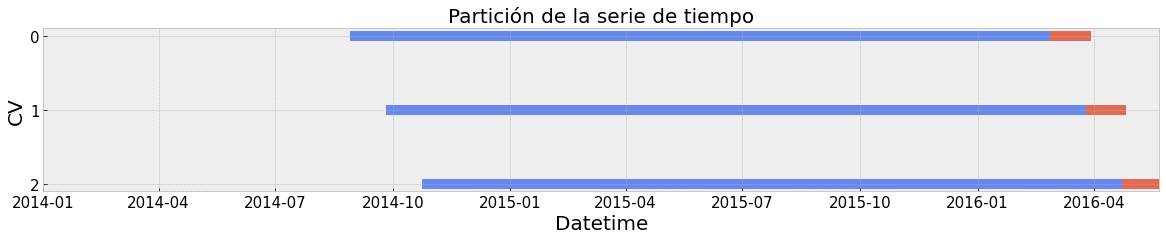

In [ ]:
plot_cv_indices(cv, sample, dt_col)

**Ejecutamos el modelo**

In [ ]:
#Obtenemos la identificacion de la tienda

%%time
stores = list(d_store_id.keys())
models = []
for store in stores:

    df = data[data['store_id']==store]
    df = df.reset_index(drop=True)
    df.drop('date', axis=1, inplace=True)
    X, y = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
    
    #Partimos los datos teniendo en cuenta la relacion temporal
    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):

      print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")
      X_train, X_valid = X.iloc[idx_trn], X.iloc[idx_val]
      y_train, y_valid = y.iloc[idx_trn], y.iloc[idx_val]

      
      
      #Primer modelo..... LGBOOST Regressor

      model = LGBMRegressor(
          n_estimators=1000,
          learning_rate=0.3,
          subsample=0.8,
          colsample_bytree=0.8,
          max_depth=8,
          num_leaves=50,
          min_child_weight=300
      )
      print('*****Predicciones para la tienda: {}*****'.format(d_store_id[store]))
      model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
              eval_metric='rmse', verbose=20, early_stopping_rounds=20)
      #valid_preds[X_valid.index] = model.predict(X_valid)
      
      models.append(model)

      filename = ruta+'modelo_LGB/'+'model'+str(d_store_id[store])+'.pkl'
      # save model
      joblib.dump(model, filename)
      del model, X_train, y_train, X_valid, y_valid, idx_trn, idx_val
    


----- Fold: (1 / 3) -----

*****Predicciones para la tienda: CA_1*****
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.237429	training's rmse: 0.487267	valid_1's l2: 0.24478	valid_1's rmse: 0.494752
[40]	training's l2: 0.193248	training's rmse: 0.4396	valid_1's l2: 0.227545	valid_1's rmse: 0.477016
[60]	training's l2: 0.174034	training's rmse: 0.417174	valid_1's l2: 0.216238	valid_1's rmse: 0.465014
[80]	training's l2: 0.156002	training's rmse: 0.394971	valid_1's l2: 0.20315	valid_1's rmse: 0.450722
[100]	training's l2: 0.143118	training's rmse: 0.37831	valid_1's l2: 0.192853	valid_1's rmse: 0.43915
[120]	training's l2: 0.136441	training's rmse: 0.369379	valid_1's l2: 0.190126	valid_1's rmse: 0.436035
[140]	training's l2: 0.130389	training's rmse: 0.361094	valid_1's l2: 0.189059	valid_1's rmse: 0.434809
[160]	training's l2: 0.121645	training's rmse: 0.348777	valid_1's l2: 0.180536	valid_1's rmse: 0.424896
[180]	training's l2: 0.115661	training's rms

**Evaluacion del modelo**

In [ ]:
##Tenemos 3 modelos por cada tienda. Vamos a realizar las predicciones y tenemos una mètrica realizando el promedio de cada uno.

models_CA1= models[0:3]
models_CA2 = models[3:6]
models_CA3 = models[6:9]
models_CA4 = models[9:12]
models_TX1 = models[12:15]
models_TX2 = models[15:18]
models_TX3 = models[18:21]
models_W1 = models[21:24]
models_W2 = models[24:27]
models_W3 = models[27:30]

models_ = {}
models_['CA_1'] = models_CA1
models_['CA_2'] = models_CA2
models_['CA_3'] = models_CA3
models_['CA_4'] = models_CA4
models_['TX_1'] = models_TX1
models_['TX_2'] = models_TX2
models_['TX_3'] = models_TX3
models_['WI_1'] = models_W1
models_['WI_2'] = models_W2
models_['WI_3'] = models_W3

df_stores = {}

for store,key in d_store_id.items():

    df_stores[key] =  X_test[X_test['store_id']==store]
    
###definicion del target para cada una de las tiendas
y_test_stores = {}

for store, df in df_stores.items():

  y_test_stores[store] = y_test.loc[df.index]

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

preds = {}

for key, df in df_stores.items():

  preds[key] = np.zeros(df.shape[0])

for store, model in models_.items():
  
    for m in model:    

      preds[store] += m.predict(df_stores[store])
      preds[store] / cv.get_n_splits()



In [ ]:
errors = {}

for store, predic in preds.items():

  errors[store] = rmse(y_test_stores[store].values, predic)


In [ ]:
errors

{'CA_1': 7.888680968245924,
 'CA_2': 7.120313735626317,
 'CA_3': 10.531286805484172,
 'CA_4': 4.357916523053722,
 'TX_1': 6.7379255198377725,
 'TX_2': 7.899581242540605,
 'TX_3': 7.810335691322196,
 'WI_1': 5.803090971240016,
 'WI_2': 10.737923024525845,
 'WI_3': 8.104978545944723}

**Funciones de desempeño**

In [ ]:
#Cargamos los modelos
models = {}
for filename in os.listdir(ruta + 'modelo_LGB/'):
    if 'model' in filename:
        #Cargando el modelo
        model = joblib.load(ruta + 'modelo_LGB/'+filename)
        models[filename] = model

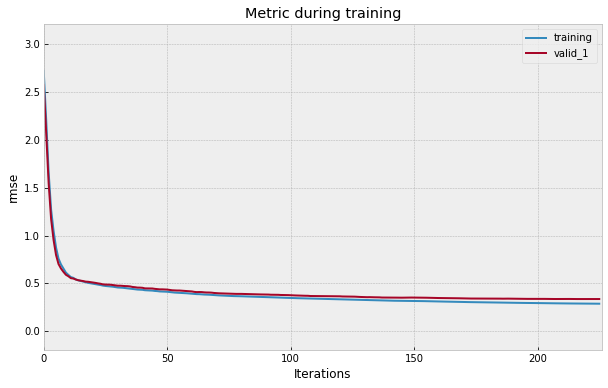

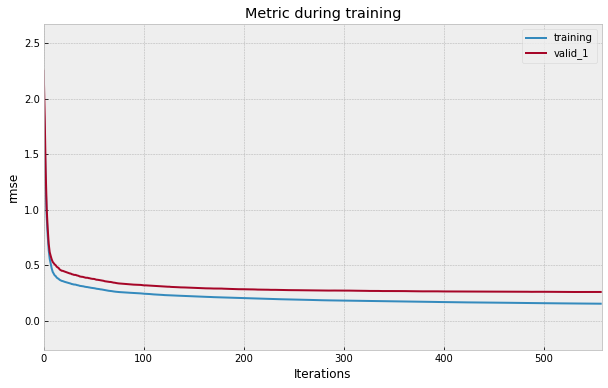

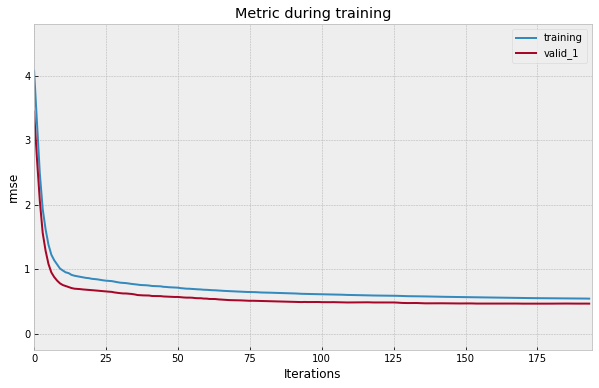

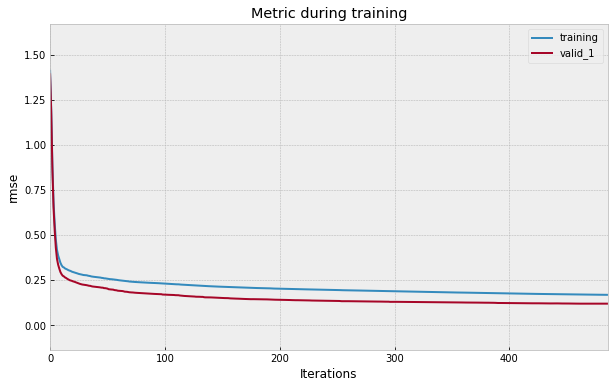

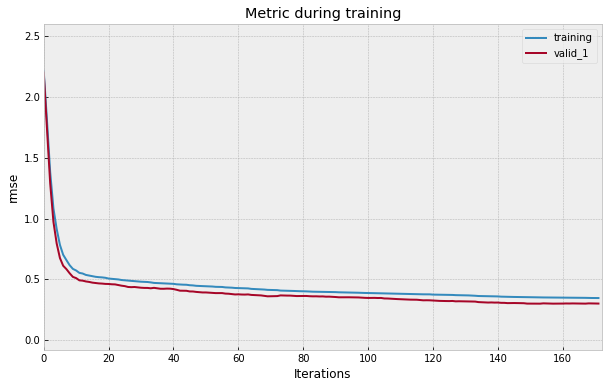

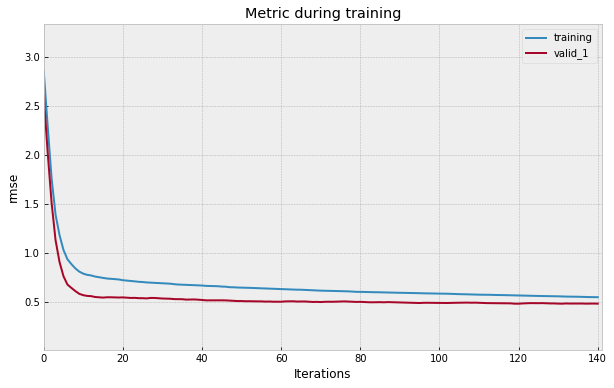

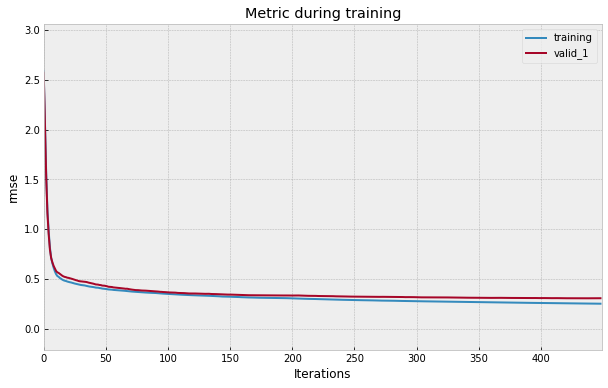

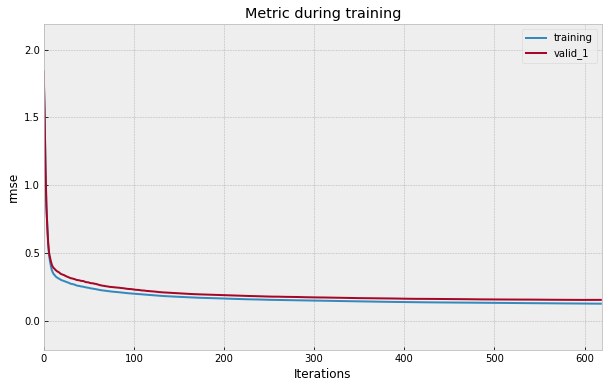

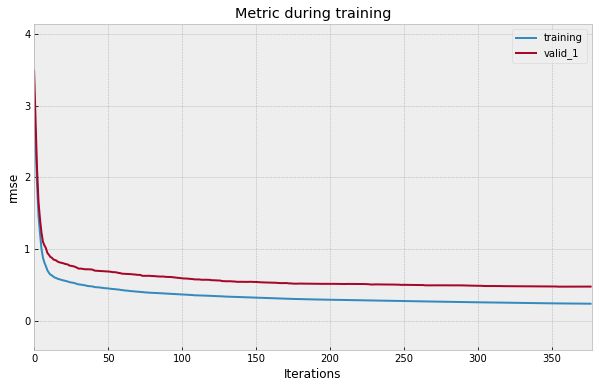

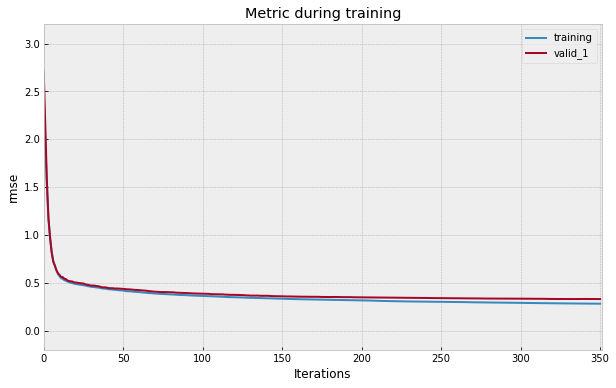

In [ ]:
for model in models.items():
  lgb.plot_metric(model[1], figsize=(10,6))
  plt.savefig(ruta+'modelo_LGB/perdida_'+model[0][:-4]+'.png', bbox_inches='tight')


**Visualizaciòn de las predicciones vs el valor real**

In [ ]:
y_train = data[data['d']<1914]['sold']
y_test = valid['sold']

**Importancia de las variables**

In [ ]:
feature_importance_df = pd.DataFrame()
features = [f for f in data.columns if f != 'sold']
for filename in os.listdir(ruta + 'modelo_LGB/'):
    if 'model' in filename:
        #Cargando el modelo
        model = joblib.load(ruta + 'modelo_LGB/'+filename)
        store_importance_df = pd.DataFrame()
        store_importance_df["feature"] = features
        store_importance_df["importance"] = model.feature_importances_
        store_importance_df["store"] = filename[5:9]
        feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)
    
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(10, 15))
    fig = px.bar(best_features.sort_values(by="importance", ascending=True), x="importance", y="feature",  title='LightGBM Variables Importantes (Promedio entre todas las tiendas evaluadas)')
    
    fig.show()
    
display_importances(feature_importance_df)
plotly.offline.plot(fig, filename = ruta+'/modelo_LGB/importancia_variables_LGB.html', auto_open=False)

'/content/drive/MyDrive/Proyecto_topicos//modelo_LGB/importancia_variables_LGB.html'

<Figure size 720x1080 with 0 Axes>

# 5. ✔️ Modelo LSTM

In [ ]:
##liberamos memoria
#del df #Liberando espacio

data = pd.read_pickle(ruta+'df_lgb.pkl')

data = downcast(data)

###Imputamos los valores nulos.
data = data.replace([np.inf, -np.inf], np.nan)
data.fillna(0, inplace=True)


In [ ]:
## Solo trabajamos con los datos de CA_3 el cual es store_id=2
data = data[data['store_id']==2].reset_index(drop=True).drop('store_id',axis=1)

In [ ]:
##Tomamos solamente la variable que vamos a predecir sold

data = data[['d', 'sold']].groupby('d').sum()
# data.index = data['d']
data = data.sort_index(ascending=True, axis=0)

# data.drop('d', axis=1, inplace=True)
data.head()

sold
d             
1069.0  4320.0
1070.0  5704.0
1071.0  6376.0
1072.0  7044.0
1073.0  7736.0

In [ ]:
# data = data.diff(periods=1).dropna()

In [ ]:
#### para entrenar nuestro modelo
X_train= data.loc[:1914]# Vamos a predecir 28 dias

###para medir su desempeño
X_test= data.loc[1914:1942]# Vamos a predecir 28 dias los dejamos para chequear nuestro modelo

In [ ]:
# # Predecimos solo para la tienda CA_3
# df_stores = {}

# df_stores['CA_3'] =  data

In [ ]:
## Escalamos los datos

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data_train  = np.squeeze(np.array(scaler.fit_transform(X_train)),axis=1)
scaled_data_test = np.squeeze(np.array(scaler.transform(X_test)),axis=1)

In [ ]:
# #Debemos realizar 10 modelos uno para cada una de las tiendas... Luego podemos intentar predecir de manera general
# df_stores = {}

# #Creamos un dataframe por cada tienda...
# for store,key in d_store_id.items():

#     df_stores[key] =  data[data['store_id']==store].drop('store_id', axis=1)


In [ ]:
# ## Escalamos los datos
# dataset = {}

# scaler = MinMaxScaler(feature_range=(0, 1))

# for store, df in df_stores.items():

#   dataset[store] = np.squeeze(np.array(scaler.fit_transform(df)),axis=1)


In [ ]:
data.to_csv('data_lstm.csv')

NameError: ignored

In [ ]:
data = pd.read_csv('data_lstm.csv')

FileNotFoundError: ignored

**Creamos los datos de entrenamiento tenemos que realizar 10 modelos, para cada tienda, pues cada tienda tiene un comportamiento diferente**

La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 28 datos (la predicción a partir de esos "time_step" datos se hace para los siguentes 28 días). Se conformará de esta forma el set de entrenamiento

* Número de datos consecutivos para entrenamiento: time_step = 100.

* Días a predecir: days = 28

**Funcion para crear los datos de entrenamiento**


In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  
    ''' dataset: conjunto de datos
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])

    return np.array(data), np.array(labels)



def create_dataset(data,timestamp=1):
    X=[]
    Y=[]
    
    for i in range(len(data)-timestamp-1):
        a = data[i:(i+timestamp)]
        X.append(a)
        
        Y.append(data[i+timestamp])
        
    return np.array(X),np.array(Y)


# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# def create_sequences(timeseries, seq_len):
#     inputs = []
#     targets = []
    
#     max_steps = len(timeseries) - (seq_len+1)
    
#     for t in range(max_steps):
#         x = timeseries[t:(t+seq_len)]
#         y = timeseries[t+seq_len]
#         inputs.append(x)
#         targets.append(y)
    
#     return np.array(inputs), np.array(targets)

# class MyLSTM(nn.Module):
    
#     def __init__(self, input_dim, hidden_dim, batch_size, num_layers=1, output_dim=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.batch_size = batch_size
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_size=self.input_dim,
#                             hidden_size=self.hidden_dim,
#                             num_layers=self.num_layers,
#                             dropout = 0.25)
#         self.linear = nn.Linear(self.hidden_dim, output_dim)
        
#     def init_hidden(self):
#         self.h_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
#         self.c_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
    
#     def forward(self, x):
#         lstm_output, (h_n, c_n) = self.lstm(x.view(len(x), self.batch_size, -1),
#                                            (self.h_zero, self.c_zero))
#         last_time_step = lstm_output.view(self.batch_size, len(x), self.hidden_dim)[-1]
#         pred = self.linear(last_time_step)
#         return pred
    

# def train_model(model, data_dict, lr=1e-4, num_epochs=500):
    
#     loss_fun = torch.nn.MSELoss(reduction="mean")
#     optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    
#     train_losses = np.zeros(num_epochs)
#     phases = ["train", "eval"]
#     losses_dict = {"train": [], "eval": []}
#     predictions_dict = {"train": [], "eval": [] }
    
#     for n in range(num_epochs):
        
#         for phase in phases:
            
#             x = data_dict[phase]["input"].to(device, dtype=torch.float)
#             y = data_dict[phase]["target"].to(device, dtype=torch.float)
            
#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()
        
#             optimiser.zero_grad()
            
#             model.init_hidden()
#             y_pred = model(x)
            
#             if n == (num_epochs-1):
#                 predictions_dict[phase] = y_pred.float().cpu().detach().numpy()
            
#             loss = loss_fun(y_pred.float(), y)
#             losses_dict[phase].append(loss.item())
            
#             if n % 50 == 0:
#                 print("{} loss: {}".format(phase, loss.item()))
            
#             if phase == 'train':
#                 loss.backward()
#                 optimiser.step()
        
#     return losses_dict, predictions_dict

In [ ]:
# seq_len = 365
# input_dim = 1
# hidden_dim = 128
# num_epochs = 600
# lr=0.0005


num_timesteps=3
X_train,y_train = create_dataset(scaled_data_train,num_timesteps)
X_test,y_test = create_dataset(scaled_data_test,num_timesteps)


X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#Creamos los tensores para train
y_train = np.reshape(y_train, (y_train.shape[0],1,1))

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))#Creamos los tensores para train
y_test = np.reshape(y_test, (y_test.shape[0],1,1))

# x_train, y_train = create_sequences(scaled_data_train, 30)
# x_eval, y_eval = create_sequences(scaled_data_test, 30)

# x_train = torch.from_numpy(x_train).float()
# y_train = torch.from_numpy(y_train).float()
# x_eval = torch.from_numpy(x_eval).float()
# y_eval = torch.from_numpy(y_eval).float()

# data_dict = {"train": {"input": x_train, "target": y_train},
#              "eval": {"input": x_eval, "target": y_eval}}

In [ ]:
# Define el modelo
# Create the Keras model.
# Use hyperparameter optimization if you have the time.

ts_inputs = tf.keras.Input(shape=(num_timesteps, 1))

# units=10 -> The cell and hidden states will be of dimension 10.
#             The number of parameters that need to be trained = 4*units*(units+2)
x = layers.LSTM(units=280)(ts_inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)
model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [ ]:
stop = EarlyStopping(monitor="val_loss", patience=1, verbose=1, mode="auto")

In [ ]:
# Specify the training configuration.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 280)               315840    
_________________________________________________________________
dropout_3 (Dropout)          (None, 280)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 281       
Total params: 316,121
Trainable params: 316,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size= 5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

#Guardamos el modelo
model.save('history_LSTM.h5')

Epoch 1/200
152/152 [==============================] - 5s 24ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 2/200
152/152 [==============================] - 2s 10ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 3/200
152/152 [==============================] - 3s 19ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 4/200
152/152 [==============================] - 1s 6ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 5/200
152/152 [==============================] - 1s 7ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6/200
152/152 [==============================] - 3s 19ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 7/200
152/152 [==============================] - 3s 20ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 8/200
152/152 [==============================] - 3s 20ms/s

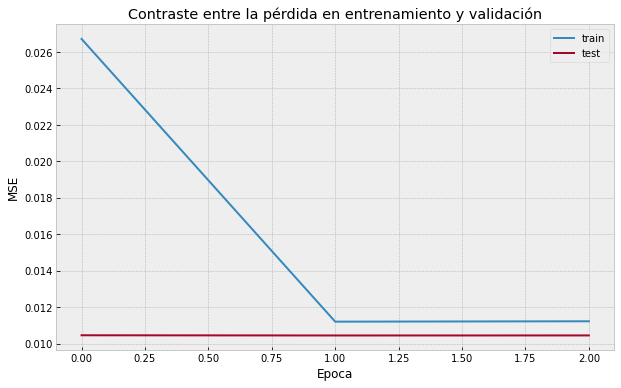

In [ ]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax1.set_xlabel("Epoca")
ax1.set_ylabel("MSE")
ax1.set_title("Contraste entre la pérdida en entrenamiento y validación")
plt.savefig("funcion_perdida_LSTM.png",bbox_inches='tight');

In [ ]:
# predicciones
pred = model.predict(X_test)

#Eliminamos las dimensiones sobrantes para poder visualizar los resultados
y_train_p = np.squeeze(y_train, axis=-1)
y_test_p =  np.squeeze(y_test, axis=-1)
y_pred_p =  np.squeeze(pred, axis=-1)

#y_test_p = y_test_p.reshape(-1)
print(y_train_p.shape)
print(y_test_p.shape)
print(y_pred_p.shape)

(841, 1)
(24,)
(24,)


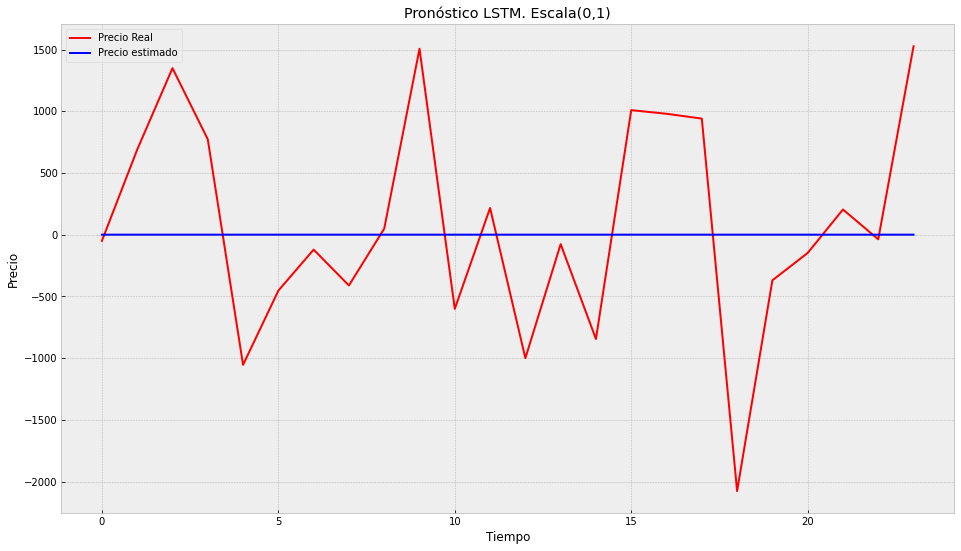

In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    plt.plot(test, color='red',label='Precio Real')
    plt.plot(predicted, color='blue',label='Precio estimado')
    plt.title('Pronóstico LSTM. Escala(0,1)')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()
    # plt.savefig("bitcoin_acercamiento_LSTM.png",bbox_inches='tight');
    plt.show()
    

    
plot_predictions(y_test_p,y_pred_p)

In [ ]:
y_test = scaler.inverse_transform(y_test_p)
y_pred = scaler.inverse_transform(pred)

rms_LSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
mse_LSTM = mean_squared_error(y_pred, y_test)
print("RMS:", rms_LSTM)
print("MSE", mse_LSTM)

RMS: 846.0018
MSE 715719.0


In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

device(type='cpu')

In [ ]:
# model = MyLSTM(input_dim=input_dim,
#                hidden_dim=hidden_dim,
#                batch_size=seq_len)
# model = model.to(device)

In [ ]:
# run_training = True
# if run_training:
#     losses_dict, predictions_dict = train_model(model, data_dict, num_epochs=num_epochs, lr=lr)

RuntimeError: ignored

In [ ]:
# #Colocamos una semilla para generalizar la productividad
# %%time

# tf.random.set_seed(100)

# # hiperparámetros para crear las secuencias
# past_history = 150 # tamaño secuencias de entrada
# future_target = 28 # días adelante



# X_train = {}
# y_train = {}

# # secuencias de entrenamiento
# for store, dataset_ in dataset.items():

#   TRAIN_SPLIT = int(len(dataset_)*0.8)
#   X_train[store], y_train[store] = univariate_data(dataset_, 0, TRAIN_SPLIT,
#                                            past_history,
#                                            future_target)
  
# ########################################################################3
# #secuencias de validación
# # No se usará ningún dato que el modelo haya visto

# X_test = {}
# y_test = {}
# for store, dataset_ in dataset.items():

#   TRAIN_SPLIT = int(len(dataset_)*0.8)
#   X_test[store], y_test[store] = univariate_data(dataset, TRAIN_SPLIT, None,
#                                        past_history,
#                                        future_target)


CPU times: user 10min 30s, sys: 32.6 s, total: 11min 3s
Wall time: 11min 5s


In [ ]:
# print(X_train['CA_1'].shape)

(2060974, 150, 1)


**Creando la arquitectura del modelo**

In [ ]:
#Todas las arquitecturas de los 10 modelos seràn iguales. Cambiaran el input
models_arqui = {}

for store, x_train in X_train.items():
  print(store)

  input_shape = (x_train.shape[1], x_train.shape[2])
  units = 180

  drop_out_rate = 0.4

  # layers
  inputs = Input(input_shape)
  x = Dropout(drop_out_rate, name= 'Dropout_01')(inputs)
  x = LSTM(units=units, name='LSTM_layer',
         dropout=drop_out_rate, recurrent_dropout=drop_out_rate, activity_regularizer = regularizers.l2(1e-5))(x)

  x = Dense(units=64, activation='relu')(x),
  x = Dropout(drop_out_rate, name= 'Dropout_02')(x)
  outputs = Dense(1)(x)

  # model
  model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
  models_arqui[store] = model_01

CA_1
CA_2
CA_3
CA_4
TX_1
TX_2
TX_3
WI_1
WI_2
WI_3


In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

###### Definimos el callbacks


callback = EarlyStopping(monitor='loss', patience=60)

########Compilamos cada uno de los modelos

for store, model in models_arqui.items():
  model.compile(loss= root_mean_squared_error,
  optimizer=Adam(0.001))

**Entrenamos cada uno de los modelos**

In [ ]:
%%time

histories = {}
for store, model in models_arqui.items():
  print('-------------------',store)
  histories[store] = model.fit(
      X_train[store], y_train[store],
      epochs=15,
      batch_size=64,
      validation_data=(X_test[store], y_test[store]),
      verbose=1,
      shuffle=False, callbacks=[callback])
  model.save(ruta+'modelo_LSTM/'+store+'_LSTM.h5')

------------------- CA_1
Epoch 1/15
 6185/32203 [====>.........................] - ETA: 5:14:32 - loss: 0.0127

## 6. 🛠️ Datos Twitter  (En construcción)

Extraer en tiempo real los datos de twitter, con las especificaciones requeridas (tema y ubicación), y crear una base de datos que vaya almacenando estos tweets para luego procesarlos.

Para entrenar la red neuronal que extraerá las emociones del texto de los tweets se implentará las siguientes bases de datos extraídas de https://archive.ics.uci.edu/ml/index.php.

### 4.1. **Datos para la extracción de emociones**
--------------------------------------------------------

In [ ]:
data = pd.read_csv(ruta+"text_emotion.csv")
data0=pd.read_csv(ruta+"train.txt", sep=';',names=["content","sentiment"])
print("Dimension de df:", data.shape)
print("Dimension de df0:", data0.shape)

Dimension de df: (40000, 4)
Dimension de df0: (16000, 2)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


Para la base de datos "text_emotions", se tiene:


In [ ]:
data.head(5)

tweet_id   sentiment       author  \
0  1956967341       empty   xoshayzers   
1  1956967666     sadness    wannamama   
2  1956967696     sadness    coolfunky   
3  1956967789  enthusiasm  czareaquino   
4  1956968416     neutral    xkilljoyx   

                                             content  
0  @tiffanylue i know  i was listenin to bad habi...  
1  Layin n bed with a headache  ughhhh...waitin o...  
2                Funeral ceremony...gloomy friday...  
3               wants to hang out with friends SOON!  
4  @dannycastillo We want to trade with someone w...

In [ ]:
data0.head(5)

content sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger

##### 4.1.1. **Preparación de los datos de entrenamiento**

In [ ]:
data=data[['content','sentiment']]
data0=data0[['content','sentiment']]
data=pd.concat([data, data0],axis=0)
data.head(4)

content   sentiment
0  @tiffanylue i know  i was listenin to bad habi...       empty
1  Layin n bed with a headache  ughhhh...waitin o...     sadness
2                Funeral ceremony...gloomy friday...     sadness
3               wants to hang out with friends SOON!  enthusiasm

**Creación del diccionario para corregir posibles errores gramaticales en las frases**

In [ ]:
misspell_data = pd.read_csv(ruta+ "spell.txt",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Muestra del diccionario
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(20)]}

{'Steffen': 'Stephen',
 'abilitey': 'ability',
 'abouy': 'about',
 'absorbtion': 'absorption',
 'accidently': 'accidentally',
 'accomodate': 'accommodate',
 'acommadate': 'accommodate',
 'acord': 'accord',
 'adultry': 'adultery',
 'aggresive': 'aggressive',
 'alchohol': 'alcohol',
 'alchoholic': 'alcoholic',
 'allieve': 'alive',
 'alright': 'all_right',
 'aquantance': 'acquaintance',
 'equire': 'acquire',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

**Datos para eliminar las contracciones de las frases**

In [ ]:
#Contracciones

contractions = pd.read_csv(ruta+"datasets_697638_1220322_contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

#Muestra

{v:cont_dic[v] for v in [list(cont_dic.keys())[k] for k in range(10)]}

{"'aight": 'alright',
 "'cause": 'because',
 "ain't": 'is not',
 "amn't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not'}

**¿Qué tipo de frases tenemos en nuestra base de datos?**

In [ ]:
fig = px.bar(pd.DataFrame(data.sentiment.value_counts()).reset_index(), x="index", y="sentiment", 
             labels={'sentiment':'Cantidad de Frases', 'index':'sentimiento'})
fig.update_layout(template='seaborn',title='Distribución de las frases por sentimiento')
fig.show()